In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
import sys

# Lambda_idx = int(sys.argv[1])
# n_external = int(sys.argv[2])
# ell_idx = int(sys.argv[3])


Lambda_idx = 18
n_external = 1000
ell_idx = 64

Lambda = Lambdas[Lambda_idx]

# CCAT-prime
zmin = 3.5
zmax = 8.1

oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_l_%d_quad.npy'%(zmin, zmax, 
                                                                                                                     Lambda_idx, 
                                                                                                                     n_external,
                                                                                                                    ell_idx)
print(oup_fname)

/scratch/users/delon/LIMxCMBL/I_auto/comb_zmin_3.5_zmax_8.1_Lambda_idx_18_n_ext_1000_l_64_quad.npy


In [2]:
Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid

external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
print('external chi spacing', np.mean(np.diff(external_chis)))

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log10(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)
f_inner_integral_LoLo = interp1d(x = chibs, y = inner_dkparp_integral, axis = 1)

external chi spacing 2.2117496122655558


In [4]:
import jax
import jax.numpy as jnp
_KI = np.array(KI)
@jax.jit
def f_KILo(chi, external_chi, Lambda):
    return (Lambda / jnp.pi 
            * jnp.interp(x = chi, xp = chis, 
                         fp = _KI, left = 0, right = 0) 
            * jnp.sinc(Lambda * (external_chi - chi) / np.pi))

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [6]:
from interpax import interp2d, interp1d
inner_dkparp_integral = jnp.array(inner_dkparp_integral.astype(np.float64))

2025-03-03 13:40:33.677242: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
from interpax import interp2d, interp1d

In [8]:
from tqdm import trange

@jax.jit
def f_integrand(_chib, ell_idx):
    #by construction chimin < exteranl_chis < chimax 
    #I Lo + Lo I
    
    _delta = jnp.abs(1 - external_chis/_chib) #(n_ext)
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chis) 
            & (2*_chib - external_chis <= chimax)) #(n_ext)
    
    cross_integrand = (2 * jnp.interp(x = external_chis, xp = chis, fp = _KI, left = 0, right = 0) 
                       * interp2d(xq = _chib, yq=jnp.log(_delta), 
                           x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral[ell_idx],
                           method='cubic',) 
                       / (_chib**2))
    
    cross_integrand = jnp.where(_idx.reshape(-1, 1),
                               cross_integrand.reshape(-1, 1)
                               * f_KILo(2*_chib - external_chis.reshape(-1,1), 
                                        external_chi = external_chis.reshape(1, -1), 
                                        Lambda=Lambda),
                                0)
    cross_integrand = cross_integrand + jnp.moveaxis(cross_integrand, -1, -2) # the two cross terms are just from switching chi and chi'
    #LoLo
    plus = _chib*(1+deltas)
    mins = _chib*(1-deltas)
    _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)
    
    LoLo_integrand  = jnp.where(_idxs,
                               f_KILo(plus, 
                                      external_chi = external_chis.reshape(-1, 1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(mins, 
                                         external_chi = external_chis.reshape(1, -1, 1), 
                                         Lambda=Lambda),
                               0)
    LoLo_integrand += jnp.where(_idxs,
                               f_KILo(mins, 
                                      external_chi = external_chis.reshape(-1, 1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(plus, 
                                         external_chi = external_chis.reshape(1, -1, 1), 
                                         Lambda=Lambda),0)
    LoLo_integrand *= (2 / _chib) #(x,y,d)
    LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, deltas)
    LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, 
                                interp1d(xq = _chib,
                                         x = chibs, f=inner_dkparp_integral[ell_idx],
                                         method='cubic',))
    
    LoLo_integrand = jnp.trapezoid(x = np.log(deltas), y = LoLo_integrand, axis=-1)
    return LoLo_integrand - cross_integrand

In [9]:
f_integrand(8080, ell_idx = 0)

Array([[1.3566736e-12, 1.3609657e-12, 1.3646055e-12, ..., 1.4126531e-12,
        1.4080109e-12, 1.4030004e-12],
       [1.3609657e-12, 1.3656628e-12, 1.3697069e-12, ..., 1.4164853e-12,
        1.4122536e-12, 1.4076521e-12],
       [1.3646055e-12, 1.3697069e-12, 1.3741553e-12, ..., 1.4196509e-12,
        1.4158359e-12, 1.4116463e-12],
       ...,
       [1.4126531e-12, 1.4164853e-12, 1.4196509e-12, ..., 1.4349958e-12,
        1.4329090e-12, 1.4301367e-12],
       [1.4080109e-12, 1.4122536e-12, 1.4158359e-12, ..., 1.4329090e-12,
        1.4312380e-12, 1.4288797e-12],
       [1.4030004e-12, 1.4076521e-12, 1.4116463e-12, ..., 1.4301367e-12,
        1.4288797e-12, 1.4269356e-12]], dtype=float32)

In [10]:
oup = np.zeros((len(ells), n_external, n_external))

In [11]:
chimax_sample

10968.67918356649

In [12]:
from quadax import quadgk

# the breakpoints are there ot make sure we focus on chimin, chimax
res, _ = quadgk(f_integrand, jnp.hstack([10, jnp.linspace(chimin, chimax, 50), chimax_sample]),
                 epsabs = 0.0, epsrel = 1e-5, 
                order = 15, max_ninter=300, args=(ell_idx,))

In [13]:
# from quadax import quadcc

# res, _ = quadcc(f_integrand, jnp.hstack([10, jnp.linspace(chimin, chimax, 50), chimax_sample]),
#                  epsabs = 0.0, epsrel = 1e-5, 
#                 order = 8, max_ninter=10000, args=(ell_idx,))

In [14]:
np.save(oup_fname, res)
print('outputted')

outputted


In [15]:
import matplotlib.pyplot as plt


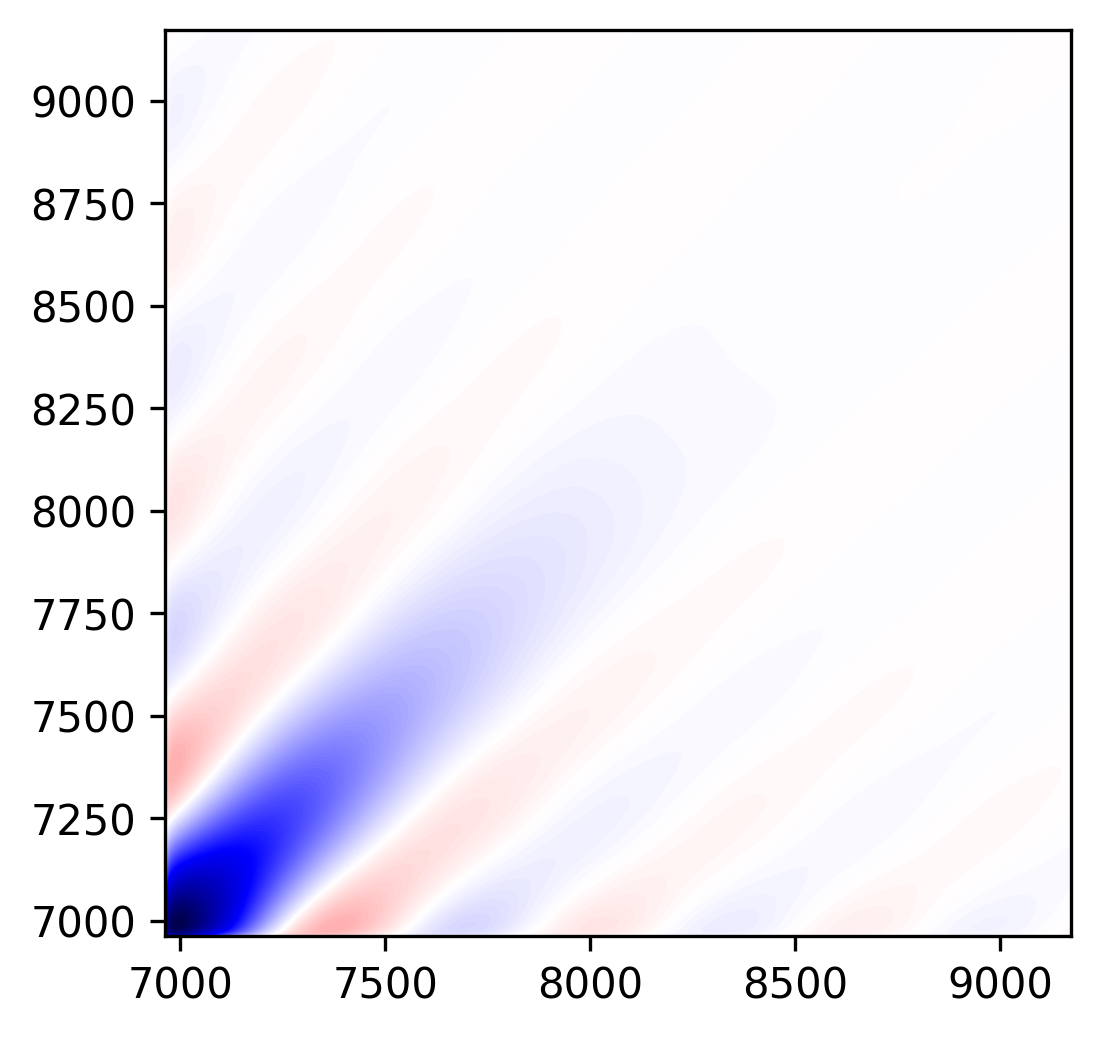

In [16]:
vb = np.max(np.abs(res))
plt.figure(dpi = 300)
plt.imshow(res,
          vmin = -vb,
          vmax = vb,
           extent=[
               chimin,
               chimax,
               chimin,
               chimax
           ],
           origin = 'lower',
          cmap = 'seismic')

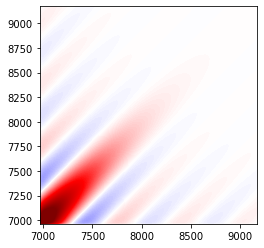

In [17]:
asdfasdf='/scratch/users/delon/LIMxCMBL/I_auto/ILo_ILo_'
asdfasdf+= 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_n_chib_%d.npy'%(zmin, 
                                                                       zmax, 
                                                                       Lambda_idx, 
                                                                       700, 
                                                                       4096) 
old_ILo_auto = np.load(asdfasdf)
asdfasdf = '/scratch/users/delon/LIMxCMBL/I_auto/I_ILo_'
asdfasdf += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_n_chib_%d.npy'%(zmin, 
                                                                        zmax, 
                                                                        Lambda_idx, 
                                                                        3000, 
                                                                        1024)
old_cross = np.load(asdfasdf)



plt.imshow(old_cross[ell_idx],
          vmin = -vb,
          vmax = vb,
           extent=[
               chimin,
               chimax,
               chimin,
               chimax
           ],
           origin = 'lower',
          cmap = 'seismic')